In [42]:
import pandas as pd
import pyodbc
import json 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [43]:
 #Đọc file config
with open("etl_config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

# Chuỗi kết nối SQL Server
conn_str = (
    f"Driver={{{config['sqlserver']['odbc_driver']}}};"
    f"Server={config['sqlserver']['server']};"
    f"Database={config['sqlserver']['database']};"
    f"Trusted_Connection=yes;"
)

# Kết nối
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
print(" Kết nối SQL Server thành công")


 Kết nối SQL Server thành công


In [44]:
import os
import pandas as pd

raw_folder = config["paths"]["raw_folder"]

# Lấy file Excel đầu tiên trong thư mục raw_data
raw_files = [f for f in os.listdir(raw_folder) if f.endswith(".xlsx")]
if not raw_files:
    raise FileNotFoundError("Không tìm thấy file Excel trong raw_data")

file_path = os.path.join(raw_folder, raw_files[0])
print(" Đang đọc file:", file_path)

# Đọc file Excel
df = pd.read_excel(file_path)
display(df.head())



 Đang đọc file: raw_data\ecommerce_data.xlsx


,HoTen,Email,NgayMua,Traffic,TinhThanh,QuanHuyen,MaDonHang,TenSanPham,TenNhomSanPham,NhaSanXuat,SKU,PhienBan,PhuongThucTT,DoanhThu,TienKhuyenMai,DoanhThuThuan,SoLuong,VanChuyen
0,Quý cô Hạnh Mai,quy.co.hanh.mai@gmail.com,26/01/2023,Facebook,Thanh Hóa,Sầm Sơn,200001,Kem nền che khuyết điểm,Face,Maybelline,100001,Dưỡng trắng sáng da,Thanh toán khi giao hàng (COD),1248352,52670,1195682,1,0
1,Quý cô Hạnh Mai,quy.co.hanh.mai@gmail.com,12/08/2023,Referral,Lâm Đồng,Di Linh,200002,Nước hoa hồng cân bằng,Skincare,Hada Labo,100002,02 Tông Trung Bình,Thanh toán khi giao hàng (COD),4448980,98073,4330907,5,20000
2,Chị Yến Hoàng,chi.yen.hoang@gmail.com,13/06/2023,Google,Khánh Hòa,Cam Ranh,200003,Tẩy trang Micellar,Tẩy trang,L’Oréal,100003,Nâng tông giảm thâm,Ví điện tử Momo/Zalopay,204502,7769,176733,1,20000
3,Chị Yến Hoàng,chi.yen.hoang@gmail.com,10/09/2024,Facebook,TP HCM,Tân Bình,200004,Nước hoa hồng cân bằng,Skincare,Hada Labo,100004,Default Title,Chuyển khoản ngân hàng,701020,38699,642321,4,20000
4,Chị Yến Hoàng,chi.yen.hoang@gmail.com,10/09/2024,Facebook,TP HCM,Tân Bình,200004,Kem nền che khuyết điểm,Face,Maybelline,100005,Default Title,Chuyển khoản ngân hàng,3262482,94412,3168070,2,0


In [45]:
# Bỏ các cột không tên
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


In [46]:
df = df.dropna(how="all")


In [47]:
df.columns = df.columns.str.strip()       # bỏ khoảng trắng thừa
df.columns = df.columns.str.replace(" ", "", regex=False)  
df.columns = df.columns.str.replace("-", "_", regex=False)  


In [48]:
# Chuyển NgayMua về datetime chuẩn
df["NgayMua"] = pd.to_datetime(df["NgayMua"], errors="coerce", dayfirst=True)

# Nếu có dòng nào không convert được -> sẽ thành NaT
print("Số dòng null ở NgayMua sau khi chuyển:", df["NgayMua"].isna().sum())


Số dòng null ở NgayMua sau khi chuyển: 0


In [49]:
print("Dữ liệu sau khi làm sạch:")
display(df.head())
print("Các cột còn lại:", df.columns.tolist())


Dữ liệu sau khi làm sạch:


,HoTen,Email,NgayMua,Traffic,TinhThanh,QuanHuyen,MaDonHang,TenSanPham,TenNhomSanPham,NhaSanXuat,SKU,PhienBan,PhuongThucTT,DoanhThu,TienKhuyenMai,DoanhThuThuan,SoLuong,VanChuyen
0,Quý cô Hạnh Mai,quy.co.hanh.mai@gmail.com,2023-01-26,Facebook,Thanh Hóa,Sầm Sơn,200001,Kem nền che khuyết điểm,Face,Maybelline,100001,Dưỡng trắng sáng da,Thanh toán khi giao hàng (COD),1248352,52670,1195682,1,0
1,Quý cô Hạnh Mai,quy.co.hanh.mai@gmail.com,2023-08-12,Referral,Lâm Đồng,Di Linh,200002,Nước hoa hồng cân bằng,Skincare,Hada Labo,100002,02 Tông Trung Bình,Thanh toán khi giao hàng (COD),4448980,98073,4330907,5,20000
2,Chị Yến Hoàng,chi.yen.hoang@gmail.com,2023-06-13,Google,Khánh Hòa,Cam Ranh,200003,Tẩy trang Micellar,Tẩy trang,L’Oréal,100003,Nâng tông giảm thâm,Ví điện tử Momo/Zalopay,204502,7769,176733,1,20000
3,Chị Yến Hoàng,chi.yen.hoang@gmail.com,2024-09-10,Facebook,TP HCM,Tân Bình,200004,Nước hoa hồng cân bằng,Skincare,Hada Labo,100004,Default Title,Chuyển khoản ngân hàng,701020,38699,642321,4,20000
4,Chị Yến Hoàng,chi.yen.hoang@gmail.com,2024-09-10,Facebook,TP HCM,Tân Bình,200004,Kem nền che khuyết điểm,Face,Maybelline,100005,Default Title,Chuyển khoản ngân hàng,3262482,94412,3168070,2,0


Các cột còn lại: ['HoTen', 'Email', 'NgayMua', 'Traffic', 'TinhThanh', 'QuanHuyen', 'MaDonHang', 'TenSanPham', 'TenNhomSanPham', 'NhaSanXuat', 'SKU', 'PhienBan', 'PhuongThucTT', 'DoanhThu', 'TienKhuyenMai', 'DoanhThuThuan', 'SoLuong', 'VanChuyen']


In [50]:
cursor.execute("""
IF OBJECT_ID('dbo.Staging_SaleData', 'U') IS NULL
BEGIN
    CREATE TABLE Staging_SaleData (
        HoTen NVARCHAR(255),
        Email NVARCHAR(255),
        NgayMua DATE,
        Traffic VARCHAR(100),
        TinhThanh NVARCHAR(100),
        QuanHuyen NVARCHAR(100),
        DonHang NVARCHAR(50),
        TenSanPham NVARCHAR(255),
        TenNhomSanPham NVARCHAR(100),
        NhaSanXuat NVARCHAR(100),
        SKU NVARCHAR(50),
        PhienBan NVARCHAR(100),
        PhuongThucTT NVARCHAR(100),
        DoanhThu FLOAT,
        TienKhuyenMai FLOAT,
        DoanhThuThuan FLOAT,
        SoLuong INT,
        VanChuyen FLOAT
    )
END
""")
conn.commit()
print(" Đã tạo bảng Staging_SaleData")


 Đã tạo bảng Staging_SaleData


In [51]:
batch_size = config["options"]["batch_size"]

for start in range(0, len(df), batch_size):
    batch = df.iloc[start:start+batch_size]

    for _, row in batch.iterrows():
        cursor.execute("""
            INSERT INTO Staging_SaleData 
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, tuple(row))

    conn.commit()
    print(f" Đã nạp {len(batch)} dòng vào Staging")


 Đã nạp 27517 dòng vào Staging


In [52]:
cursor.execute("""
IF OBJECT_ID('dbo.Dim_KhachHang', 'U') IS NULL
BEGIN
    CREATE TABLE Dim_KhachHang (
        KhachHangID INT IDENTITY(1,1) PRIMARY KEY,
        HoTen NVARCHAR(255),
        Email NVARCHAR(255),
        TinhThanh NVARCHAR(100),
        QuanHuyen NVARCHAR(100),
        Traffic NVARCHAR(100)
    )
END
""")
conn.commit()
print(" Đã tạo Dim_KhachHang")


 Đã tạo Dim_KhachHang


In [53]:
cursor.execute("""
IF OBJECT_ID('dbo.Dim_NhomSP', 'U') IS NULL
BEGIN
    CREATE TABLE Dim_NhomSP (
        NhomSPID INT IDENTITY(1,1) PRIMARY KEY,
        TenNhomSanPham NVARCHAR(100)
    )
END
""")
conn.commit()
print(" Đã tạo Dim_NhomSP")


 Đã tạo Dim_NhomSP


In [54]:
cursor.execute("""
IF OBJECT_ID('dbo.Dim_SP', 'U') IS NULL
BEGIN
    CREATE TABLE Dim_SP (
        SPID INT IDENTITY(1,1) PRIMARY KEY,   -- Khóa chính kỹ thuật
        SKU NVARCHAR(50) NOT NULL,            -- SKU là mã duy nhất
        TenSanPham NVARCHAR(255),
        NhaSanXuat NVARCHAR(100),
        PhienBan NVARCHAR(100),
        CONSTRAINT UQ_DimSP_SKU UNIQUE (SKU)  -- Đảm bảo không trùng SKU
    )
END
""")
conn.commit()
print(" Đã tạo Dim_SP với UNIQUE(SKU)")



 Đã tạo Dim_SP với UNIQUE(SKU)


In [55]:
# Xóa các dòng trùng SKU, chỉ giữ lại 1 dòng duy nhất (SPID nhỏ nhất)
cursor.execute("""
;WITH CTE AS (
    SELECT 
        SPID,
        SKU,
        ROW_NUMBER() OVER (PARTITION BY SKU ORDER BY SPID) AS rn
    FROM Dim_SP
)
DELETE FROM CTE WHERE rn > 1;
""")
conn.commit()
print("✅ Đã xoá SKU trùng, chỉ giữ lại 1 bản ghi duy nhất cho mỗi SKU")


✅ Đã xoá SKU trùng, chỉ giữ lại 1 bản ghi duy nhất cho mỗi SKU


In [56]:
cursor.execute("""
IF OBJECT_ID('dbo.Dim_Date', 'U') IS NULL
BEGIN
    CREATE TABLE Dim_Date (
        DateID INT IDENTITY(1,1) PRIMARY KEY,
        Ngay DATE,
        Thang INT,
        Quy INT,
        Nam INT
    )
END
""")
conn.commit()
print(" Đã tạo Dim_Date")


 Đã tạo Dim_Date


In [57]:
cursor.execute("""
IF OBJECT_ID('dbo.Fact_DonHang', 'U') IS NULL
BEGIN
    CREATE TABLE Fact_DonHang (
        DonHang NVARCHAR(50),   -- Mã đơn hàng gốc
        KhachHangID INT,
        SPID INT,
        NhomSPID INT,
        DateID INT,
        SoLuong INT,
        DoanhThu FLOAT,
        TienKhuyenMai FLOAT,
        DoanhThuThuan FLOAT,
        VanChuyen FLOAT,
        PRIMARY KEY (DonHang, SPID),   -- Khóa chính kép
        FOREIGN KEY (KhachHangID) REFERENCES Dim_KhachHang(KhachHangID),
        FOREIGN KEY (SPID) REFERENCES Dim_SP(SPID),
        FOREIGN KEY (NhomSPID) REFERENCES Dim_NhomSP(NhomSPID),
        FOREIGN KEY (DateID) REFERENCES Dim_Date(DateID)
    )
END
""")
conn.commit()
print(" Đã tạo Fact_DonHang với PK (DonHang, SPID)")


 Đã tạo Fact_DonHang với PK (DonHang, SPID)


In [58]:
cursor.execute("""
;WITH LatestCustomer AS (
    SELECT 
        s.Email,
        s.HoTen,
        s.TinhThanh,
        s.QuanHuyen,
        s.Traffic,
        ROW_NUMBER() OVER (PARTITION BY s.Email ORDER BY s.NgayMua DESC) AS rn
    FROM Staging_SaleData s
)
INSERT INTO Dim_KhachHang (HoTen, Email, TinhThanh, QuanHuyen, Traffic)
SELECT HoTen, Email, TinhThanh, QuanHuyen, Traffic
FROM LatestCustomer lc
WHERE rn = 1
  AND NOT EXISTS (
      SELECT 1 FROM Dim_KhachHang kh WHERE kh.Email = lc.Email
  );
""")
conn.commit()
print(" Đã nạp dữ liệu vào Dim_KhachHang")




 Đã nạp dữ liệu vào Dim_KhachHang


In [59]:
cursor.execute("""
;WITH CTE AS (
    SELECT 
        s.SKU,
        s.TenSanPham,
        s.NhaSanXuat,
        s.PhienBan,
        ROW_NUMBER() OVER (PARTITION BY s.SKU ORDER BY s.TenSanPham) AS rn
    FROM Staging_SaleData s
    WHERE s.SKU IS NOT NULL
)
INSERT INTO Dim_SP (SKU, TenSanPham, NhaSanXuat, PhienBan)
SELECT SKU, TenSanPham, NhaSanXuat, PhienBan
FROM CTE
WHERE rn = 1;
""")
conn.commit()
print(" Đã nạp dữ liệu vào Dim_SP (mỗi SKU 1 bản duy nhất)")

 Đã nạp dữ liệu vào Dim_SP (mỗi SKU 1 bản duy nhất)


In [60]:
cursor.execute("""
INSERT INTO Dim_NhomSP (TenNhomSanPham)
SELECT DISTINCT s.TenNhomSanPham
FROM Staging_SaleData s
WHERE NOT EXISTS (
    SELECT 1 FROM Dim_NhomSP ns WHERE ns.TenNhomSanPham = s.TenNhomSanPham
)
""")
conn.commit()
print(" Đã nạp dữ liệu vào Dim_NhomSP")


 Đã nạp dữ liệu vào Dim_NhomSP


In [61]:
cursor.execute("""
INSERT INTO Dim_Date (Ngay)
SELECT DISTINCT s.NgayMua
FROM Staging_SaleData s
WHERE NOT EXISTS (
    SELECT 1 FROM Dim_Date d WHERE d.Ngay = s.NgayMua
)
""")
conn.commit()
print(" Đã nạp dữ liệu vào Dim_Date")


 Đã nạp dữ liệu vào Dim_Date


In [62]:
cursor.execute("""
UPDATE Dim_Date
SET 
    Thang = MONTH(Ngay),
    Quy   = DATEPART(QUARTER, Ngay),
    Nam   = YEAR(Ngay)
WHERE Thang IS NULL OR Quy IS NULL OR Nam IS NULL
""")
conn.commit()
print(" Đã cập nhật Thang/Quy/Nam cho Dim_Date")


 Đã cập nhật Thang/Quy/Nam cho Dim_Date


In [63]:
cursor.execute("""
INSERT INTO Fact_DonHang (
    DonHang, KhachHangID, SPID, NhomSPID, DateID,
    SoLuong, DoanhThu, TienKhuyenMai, DoanhThuThuan, VanChuyen
)
SELECT DISTINCT
    s.DonHang,               -- Mã đơn hàng gốc từ staging
    kh.KhachHangID,
    sp.SPID,
    ns.NhomSPID,
    d.DateID,
    s.SoLuong,
    s.DoanhThu,
    s.TienKhuyenMai,
    s.DoanhThuThuan,
    s.VanChuyen
FROM Staging_SaleData s
JOIN Dim_KhachHang kh ON s.Email = kh.Email
JOIN Dim_SP sp ON s.SKU = sp.SKU
JOIN Dim_NhomSP ns ON s.TenNhomSanPham = ns.TenNhomSanPham
JOIN Dim_Date d ON s.NgayMua = d.Ngay;
""")
conn.commit()
print(" Đã nạp dữ liệu vào Fact_DonHang")

 Đã nạp dữ liệu vào Fact_DonHang


Tính RFM và KMean 


In [64]:
# 2. Viết câu SQL để gọi bảng
query = "SELECT * FROM Fact_DonHang"

# 3. Đọc dữ liệu vào DataFrame pandas
df = pd.read_sql(query, conn)

# 4. Xem dữ liệu
print(df.dtypes)   # Xem kiểu dữ liệu của các cột

C:\Users\ngoc bich\AppData\Local\Temp\ipykernel_7992\1398375828.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


DonHang           object
KhachHangID        int64
SPID               int64
NhomSPID           int64
DateID             int64
SoLuong            int64
DoanhThu         float64
TienKhuyenMai    float64
DoanhThuThuan    float64
VanChuyen        float64
dtype: object


In [78]:
import pandas as pd 
# Lấy dữ liệu từ Fact + Dim_Date
query = """
SELECT 
    f.KhachHangID,
    f.DonHang,
    d.Ngay,
    f.DoanhThuThuan
FROM Fact_DonHang f
JOIN Dim_Date d ON f.DateID = d.DateID
"""
df = pd.read_sql(query, conn)
df["Ngay"] = pd.to_datetime(df["Ngay"], errors="coerce").fillna(pd.Timestamp("2021-04-04"))
# Đảm bảo cột ngày ở dạng datetime
df["Ngay"] = pd.to_datetime(df["Ngay"])
# B1: Xác định ngày tham chiếu (lấy ngày lớn nhất + 1)
ngay_tham_chieu = df["Ngay"].max() + pd.Timedelta(days=1)
print("Ngày tham chiếu:", ngay_tham_chieu)

# B2: Gom nhóm theo khách hàng
df_rfm = df.groupby("KhachHangID").agg(
    NgayMuaGanNhat=("Ngay", "max"),          
    SoLanMua=("DonHang", "nunique"),         
    TongTien=("DoanhThuThuan", "sum"),       
    NgayDauTien=("Ngay", "min")              
).reset_index()

# B3: Tính Recency, Frequency, Monetary
# df_rfm["Recency"] = (ngay_tham_chieu - df_rfm["NgayMuaGanNhat"]).dt.days
# df_rfm["TuoiKH"] = ((ngay_tham_chieu - df_rfm["NgayDauTien"]).dt.days // 365) + 1
# df_rfm["Frequency"] = df_rfm["SoLanMua"] / df_rfm["TuoiKH"]
# df_rfm["Monetary"] = df_rfm["TongTien"]
# Tính Recency (số ngày kể từ lần mua gần nhất đến ngày tham chiếu)
df_rfm["Recency"] = (ngay_tham_chieu - df_rfm["NgayMuaGanNhat"]).dt.days

# Frequency = số lần mua (không chia cho tuổi KH)
df_rfm["Frequency"] = df_rfm["SoLanMua"]

# Monetary = tổng tiền khách đã chi
df_rfm["Monetary"] = df_rfm["TongTien"]

# Kết quả cuối cùng
df_rfm_final = df_rfm[["KhachHangID", "Recency", "Frequency", "Monetary"]]
cursor.execute("""
IF OBJECT_ID('RFM_KhachHang', 'U') IS NULL
BEGIN
    CREATE TABLE RFM_KhachHang (
        KhachHangID INT PRIMARY KEY,
        Recency INT,
        Frequency FLOAT,
        Monetary FLOAT
    );
END
""")
conn.commit()

for _, row in df_rfm_final.iterrows():
    cursor.execute("""
        MERGE RFM_KhachHang AS target
        USING (SELECT ? AS KhachHangID, ? AS Recency, ? AS Frequency, ? AS Monetary) AS source
        ON target.KhachHangID = source.KhachHangID
        WHEN MATCHED THEN
            UPDATE SET Recency = source.Recency,
                       Frequency = source.Frequency,
                       Monetary = source.Monetary
        WHEN NOT MATCHED THEN
            INSERT (KhachHangID, Recency, Frequency, Monetary)
            VALUES (source.KhachHangID, source.Recency, source.Frequency, source.Monetary);
    """, row.KhachHangID, int(row.Recency), float(row.Frequency), float(row.Monetary))

conn.commit()
print(" Đã cập nhật bảng RFM_KhachHang thành công!")



C:\Users\ngoc bich\AppData\Local\Temp\ipykernel_7992\3938757321.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Ngày tham chiếu: 2024-12-31 00:00:00
 Đã cập nhật bảng RFM_KhachHang thành công!


# Chuẩn hóa dữ liệu trước khi dùng Kmean


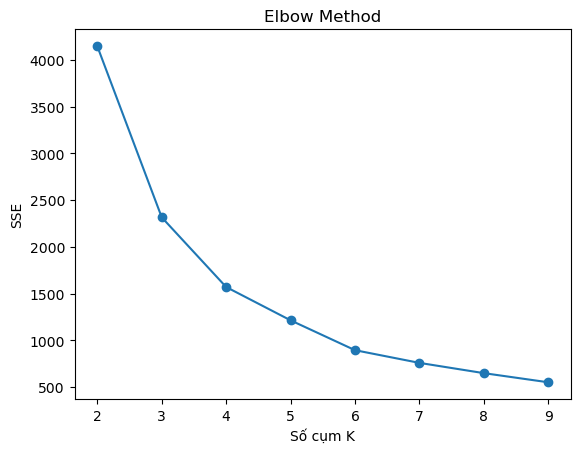

K=2, Silhouette Score=0.578
K=3, Silhouette Score=0.494
K=4, Silhouette Score=0.506
K=5, Silhouette Score=0.420
K=6, Silhouette Score=0.433
K=7, Silhouette Score=0.401
K=8, Silhouette Score=0.389
K=9, Silhouette Score=0.388
   KhachHangID  Recency  Frequency     Monetary  Cluster
0            1      245          3   10653484.0        0
1            2       56          6   32947390.0        0
2            3       22         12  105486156.0        2
3            4      199          3    3990284.0        0
4            5      102          3    9717798.0        0
📌 Trung bình RFM theo cụm:
         Recency  Frequency     Monetary
Cluster                                 
0         120.89       3.60   20,198,262
1         473.78       1.74    9,607,635
2          49.61      14.05   81,584,357
3          23.47      32.86  192,375,036


C:\Users\ngoc bich\AppData\Local\Temp\ipykernel_7992\2088584215.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm_final["Cluster"] = kmeans.fit_predict(X_scaled)


✅ Đã lưu kết quả phân cụm vào bảng Customer_Segmentation trong DB!


In [87]:

# ==========================================
# Bước 6. Chuẩn hóa dữ liệu (Scaling)
# ==========================================
X = df_rfm_final[["Recency", "Frequency", "Monetary"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ==========================================
# Bước 7. Chọn số cụm K (Elbow + Silhouette)
# ==========================================
sse = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Vẽ Elbow chart
plt.plot(K_range, sse, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# In silhouette score
for k, score in zip(K_range, sil_scores):
    print(f"K={k}, Silhouette Score={score:.3f}")

# 👉 Bạn nhìn biểu đồ và Silhouette Score để chọn K phù hợp (ví dụ K=4)

# ==========================================
# Bước 8. Chạy KMeans với K đã chọn
# ==========================================
optimal_k = 4 # đổi theo kết quả bạn chọn
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_rfm_final["Cluster"] = kmeans.fit_predict(X_scaled)

print(df_rfm_final.head())

# ==========================================
# Bước 9. Phân tích cụm
# ==========================================

summary = df_rfm_final.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean()
summary = summary.round(2)
summary["Monetary"] = summary["Monetary"].apply(lambda x: f"{x:,.0f}")
print("📌 Trung bình RFM theo cụm:")
print(summary)

# ==========================================
# Bước 10. Lưu kết quả phân cụm vào DB
# ==========================================
# Tạo bảng nếu chưa có
cursor.execute("""
IF OBJECT_ID('Customer_Segmentation', 'U') IS NULL
BEGIN
    CREATE TABLE Customer_Segmentation (
        KhachHangID INT PRIMARY KEY,
        Recency INT,
        Frequency FLOAT,
        Monetary FLOAT,
        Cluster INT
    );
END
""")
conn.commit()

# Update hoặc Insert (MERGE) cho từng khách hàng
for _, row in df_rfm_final.iterrows():
    cursor.execute("""
        MERGE Customer_Segmentation AS target
        USING (SELECT ? AS KhachHangID, ? AS Recency, ? AS Frequency, ? AS Monetary, ? AS Cluster) AS source
        ON target.KhachHangID = source.KhachHangID
        WHEN MATCHED THEN
            UPDATE SET Recency = source.Recency,
                       Frequency = source.Frequency,
                       Monetary = source.Monetary,
                       Cluster = source.Cluster
        WHEN NOT MATCHED THEN
            INSERT (KhachHangID, Recency, Frequency, Monetary, Cluster)
            VALUES (source.KhachHangID, source.Recency, source.Frequency, source.Monetary, source.Cluster);
    """, row.KhachHangID, int(row.Recency), float(row.Frequency), float(row.Monetary), int(row.Cluster))

conn.commit()
print("✅ Đã lưu kết quả phân cụm vào bảng Customer_Segmentation trong DB!")


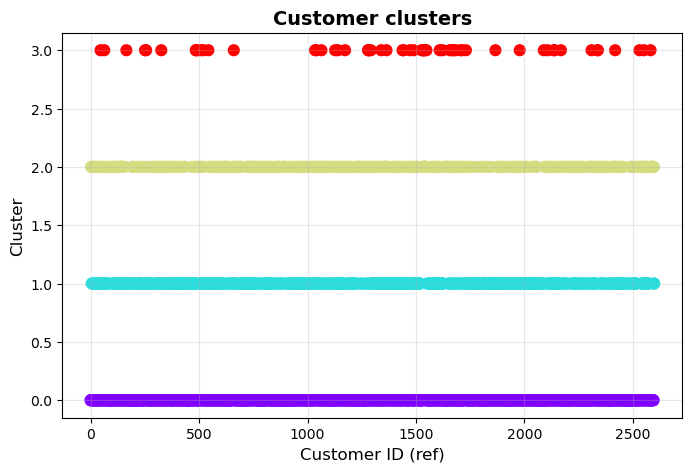

In [88]:
import matplotlib.pyplot as plt

# Vẽ scatter plot: Customer ID vs Cluster
plt.figure(figsize=(8,5))
plt.scatter(df_rfm_final.index, df_rfm_final["Cluster"], 
            c=df_rfm_final["Cluster"], cmap="rainbow", s=60)

plt.title("Customer clusters", fontsize=14, fontweight="bold")
plt.xlabel("Customer ID (ref)", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


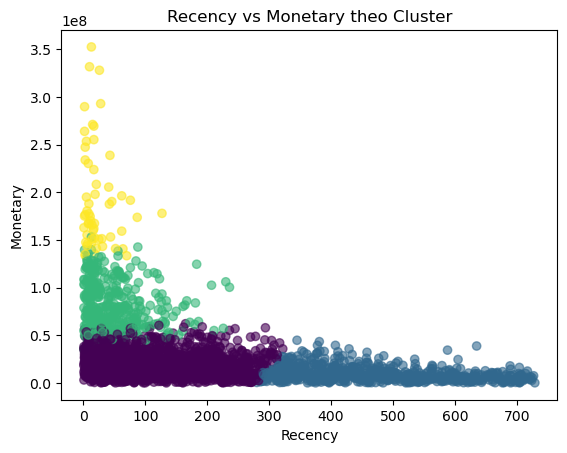

In [89]:
plt.scatter(df_rfm_final["Recency"], df_rfm_final["Monetary"],
            c=df_rfm_final["Cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("Recency vs Monetary theo Cluster")
plt.show()


In [90]:
import pandas as pd

# Giả sử bạn đã đọc lại bảng Customer_Segmentation vào df
num_clusters = df_rfm_final["Cluster"].nunique()
print("Số lượng cluster khác nhau:", num_clusters)

# Đếm số khách hàng trong từng cluster
cluster_counts = df_rfm_final["Cluster"].value_counts().sort_index()
print(cluster_counts)


Số lượng cluster khác nhau: 4
Cluster
0    1523
1     644
2     374
3      58
Name: count, dtype: int64


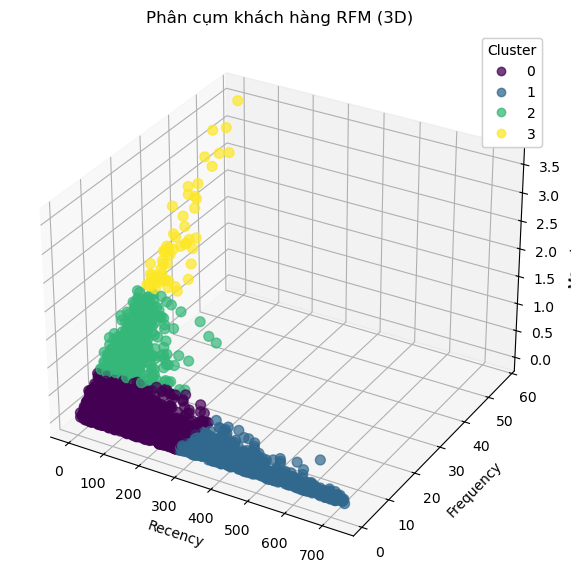

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giả sử df có các cột: Recency, Frequency, Monetary, Cluster
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_rfm_final["Recency"], 
    df_rfm_final["Frequency"], 
    df_rfm_final["Monetary"], 
    c=df_rfm_final["Cluster"],  # màu theo cluster
    cmap="viridis",   # bảng màu: viridis / tab10 / rainbow...
    s=50,             # kích thước điểm
    alpha=0.7
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("Phân cụm khách hàng RFM (3D)")

# Thêm chú giải
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()

